In [1]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
train_data = pd.read_table('ratings_train.txt')[['document','label']]
test_data = pd.read_table('ratings_test.txt')[['document','label']]
data=pd.concat((train_data,test_data),axis=0)
data = data.rename(columns={'label': 'y', 'document': 'X'})

In [3]:
class 한글_전처리기:

    def __init__(self,data):
        data['clean_X'] = data['X']
        data['y_name'] = data['y']
        data['encoder_y'] = LabelEncoder().fit_transform(data['y'])
        data['categorical_y'] = list(to_categorical(data['encoder_y']))
        s_w = set(['은', '는', '이', '가', '를', '들', '에게', '의', '을', '도', '으로', '만', '라서', '하다'])
        self.data = data
        self.s_w = s_w
    def ck_m(self):
        print(f'결측치 확인:{self.data.isnull().values.any()}')
        print(f"X 중복 확인:{self.data['clean_X'].nunique(),len(self.data['clean_X'])}\n"
              f"y 중복 확인:{self.data['y'].nunique(),len(self.data['y'])}")
    def 전처리_결과_출력(self,n=1):
        self.data['clean_X'].replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', inplace=True)
        self.data['clean_X'].replace('^ +', '', inplace=True)
        self.data['clean_X'].replace('', np.nan, inplace=True)
        self.data = self.data.dropna(how='any')
        
        okt = Okt()
        X_data = []
        for i in tqdm(self.data['clean_X']):
            tk_d = okt.morphs(i)
            end_d = [w for w in tk_d if not w in self.s_w]
            X_data.append(' '.join(end_d))
            
        if n == 1:
            Y = np.array(self.data['encoder_y'])
        else:
            Y = to_categorical(self.data['encoder_y'])
            
        X = np.array(X_data)
        x_data, test_x, y_data, test_y = train_test_split(X, Y, test_size=0.3, random_state=0)
        train_x, val_x, train_y, val_y = train_test_split(x_data, y_data, test_size=0.2, random_state=0)
        tk = Tokenizer()
        tk.fit_on_texts(train_x)
        n = len([d for d in sorted(list(tk.word_counts.items()), key=lambda x: x[1]) if d[1] > 4]) + 1
        token = Tokenizer(n)
        token.fit_on_texts(train_x)
        token_train_x = token.texts_to_sequences(train_x)
        token_test_x = token.texts_to_sequences(test_x)
        token_val_x = token.texts_to_sequences(val_x)
        drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]
        drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1]
        drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1]
        token_train_x = np.delete(token_train_x, drop_train, axis=0)
        train_y = np.delete(train_y, drop_train, axis=0)
        token_test_x = np.delete(token_test_x, drop_test, axis=0)
        test_y = np.delete(test_y, drop_test, axis=0)
        token_val_x = np.delete(token_val_x, drop_val, axis=0)
        val_y = np.delete(val_y, drop_val, axis=0)
        w_l = len(pad_sequences(token_train_x)[0])
        train_inputs = pad_sequences(token_train_x, maxlen=w_l)
        test_inputs = pad_sequences(token_test_x, maxlen=w_l)
        val_inputs = pad_sequences(token_val_x, maxlen=w_l)
        train_outputs = train_y
        test_outputs = test_y
        val_outputs = val_y
        return train_inputs, train_outputs, test_inputs, test_outputs, val_inputs, val_outputs

In [4]:
pr_mc=한글_전처리기(data)
pr_mc.ck_m()
t_x,t_y,tt_x,tt_y,v_x,v_y=pr_mc.전처리_결과_출력()
print(t_x.shape,t_y.shape,tt_x.shape,tt_y.shape,v_x.shape,v_y.shape)

결측치 확인:True
X 중복 확인:(194543, 200000)
y 중복 확인:(2, 200000)


100%|██████████████████████████████████████████████████████████████████████████████| 199992/199992 [19:13<00:00, 173.35it/s]
C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(111226, 70) (111226,) (59568, 70) (59568,) (27803, 70) (27803,)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, LSTM, GRU,BatchNormalization,Bidirectional
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [36]:
n = len(np.unique([i for i in t_x]))+1
n

18586

In [39]:
mc1 = ModelCheckpoint('best_m1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
m1 = Sequential()
m1.add(Embedding(n, 128)) 
m1.add(SimpleRNN(128,dropout=0.5,return_sequences=True)) 
m1.add(SimpleRNN(64,dropout=0.5))
m1.add(Dense(1, activation='sigmoid'))
m1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history1 = m1.fit(t_x, t_y,epochs=15, callbacks=[es, mc1],batch_size=64,  validation_data=(v_x,v_y) )

Epoch 1/15
1738/1738 [==============================] - 168s 96ms/step - loss: 0.4937 - acc: 0.7438 - val_loss: 0.3767 - val_acc: 0.8365

Epoch 00001: val_acc improved from -inf to 0.83646, saving model to best_m1.h5
Epoch 2/15
1738/1738 [==============================] - 163s 94ms/step - loss: 0.3451 - acc: 0.8534 - val_loss: 0.3628 - val_acc: 0.8494

Epoch 00002: val_acc improved from 0.83646 to 0.84940, saving model to best_m1.h5
Epoch 3/15
1738/1738 [==============================] - 157s 90ms/step - loss: 0.3306 - acc: 0.8599 - val_loss: 0.3505 - val_acc: 0.8533

Epoch 00003: val_acc improved from 0.84940 to 0.85333, saving model to best_m1.h5
Epoch 4/15
1738/1738 [==============================] - 152s 88ms/step - loss: 0.3292 - acc: 0.8627 - val_loss: 0.3626 - val_acc: 0.8435

Epoch 00004: val_acc did not improve from 0.85333
Epoch 5/15
1738/1738 [==============================] - 164s 94ms/step - loss: 0.2956 - acc: 0.8775 - val_loss: 0.3514 - val_acc: 0.8503

Epoch 00005: val_

In [40]:
ck1=m1.evaluate(tt_x, tt_y)

1862/1862 [==============================] - 24s 13ms/step - loss: 0.3639 - acc: 0.8454


In [42]:
# mc2 = ModelCheckpoint('best_m2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# m2 = Sequential()
# m2.add(Embedding(n, 128))
# m2.add(LSTM(128,dropout=0.5,return_sequences=True)) 
# m2.add(LSTM(64,dropout=0.5)) 
# m2.add(Dense(1, activation='sigmoid'))
# m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# history2 = m2.fit(t_x, t_y,epochs=15, callbacks=[es, mc2],batch_size=64,  validation_data=(v_x,v_y) )

In [43]:
# ck2=m2.evaluate(tt_x, tt_y)

In [44]:
# mc3 = ModelCheckpoint('best_m3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# m3 = Sequential()
# m3.add(Embedding(n, 128))
# m3.add(GRU(128,dropout=0.5,return_sequences=True)) 
# m3.add(GRU(64,dropout=0.5)) 
# m3.add(Dense(1, activation='sigmoid'))
# m3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# history3 = m3.fit(t_x, t_y,epochs=15, callbacks=[es, mc3],batch_size=64,  validation_data=(v_x,v_y) )

In [45]:
# ck3=m3.evaluate(tt_x, tt_y)

In [46]:
# mc4 = ModelCheckpoint('best_m4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# m4 = Sequential()
# m4.add(Embedding(n, 128))
# m4.add(Bidirectional(LSTM(128,dropout=0.5,return_sequences=True)))
# m4.add(Bidirectional(LSTM(64,dropout=0.5))) 
# m4.add(Dense(1, activation='sigmoid'))
# m4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# history4 = m4.fit(t_x, t_y,epochs=15, callbacks=[es, mc4],batch_size=64,  validation_data=(v_x,v_y) )

In [47]:
# ck4=m4.evaluate(tt_x, tt_y)

In [48]:
# print(ck1,ck2,ck3,ck4,sep='\n')

In [49]:
# ck_v_1=m1.evaluate(v_x, v_y)
# ck_v_2=m2.evaluate(v_x, v_y)
# ck_v_3=m3.evaluate(v_x, v_y)
# ck_v_4=m4.evaluate(v_x, v_y)
# print(ck_v_1,ck_v_2,ck_v_3,ck_v_4,sep='\n')

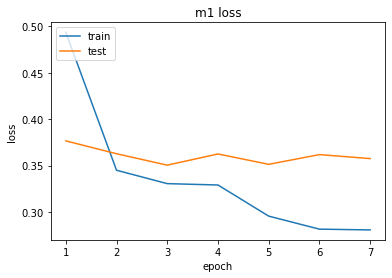

In [41]:
epochs = range(1, len(history1.history['acc']) + 1)
plt.plot(epochs, history1.history['loss'])
plt.plot(epochs, history1.history['val_loss'])
plt.title('m1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
# epochs = range(1, len(history2.history['acc']) + 1)
# plt.plot(epochs, history2.history['loss'])
# plt.plot(epochs, history2.history['val_loss'])
# plt.title('m2 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [51]:
# epochs = range(1, len(history3.history['acc']) + 1)
# plt.plot(epochs, history3.history['loss'])
# plt.plot(epochs, history3.history['val_loss'])
# plt.title('m3 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [52]:
# epochs = range(1, len(history4.history['acc']) + 1)
# plt.plot(epochs, history4.history['loss'])
# plt.plot(epochs, history4.history['val_loss'])
# plt.title('m4 loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()